In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e, Rx, Survey

In [2]:
figdir = "./figures/"

In [3]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
import matplotlib 
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams["image.cmap"] = "RdBu_r"

(-500, 0)

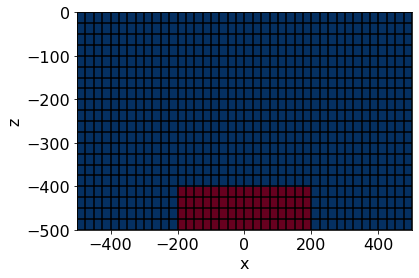

In [4]:
dz = 50.
sig_1 = 0.001

cs, ncx, ncz, npad = 25., 25, 40, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    

i = 8
sig_2 = sig_1*100.
sigmaInf = np.ones(mesh.nC) * sig_1
airind = mesh.gridCC[:,2]>0.
blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz*i)&(mesh.gridCC[:,2]<-dz*i))
sigmaInf[airind] = 1e-8
sigmaInf[blkind] = sig_2
mesh.plotImage(np.log10(sigmaInf), clim=(-3, -1), mirror=True, grid=True)
plt.xlim(-500, 500)
plt.ylim(-500, 0)

In [5]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])

In [6]:
dz = 50.
sig_1 = 0.001
data_list_siginf_sig_2 = []
data_em_list_siginf_sig_2 = []
data_ip_list_siginf_sig_2 = []
for i in range(8):
    sig_2 = sig_1*100.
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz*i)&(mesh.gridCC[:,2]<-dz*i))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_siginf_sig_2.append(data) 
    
    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em = survey_em.dpred(m)
    data_em_list_siginf_sig_2.append(data_em) 
    data_ip_list_siginf_sig_2.append(data - data_em)

0.1 0.001 0.7


/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7


In [7]:
area = np.pi*(13**2)
noise_floor = 1e-4

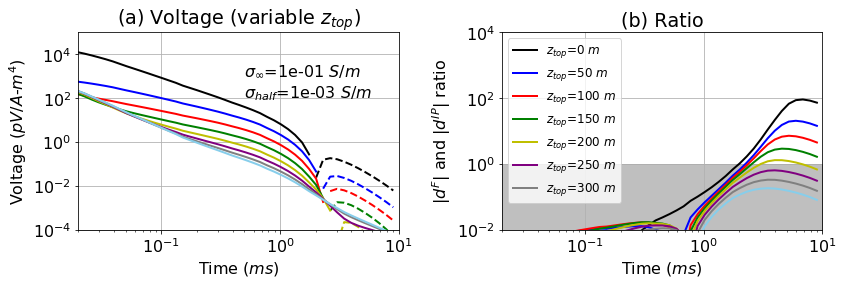

In [8]:
moment = np.pi*src_emip.radius**2 / 1e12
depths = abs(np.arange(7)*dz)
fig = plt.figure(figsize = (12, 4.))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$z_{top}$=%.0f $m$")%(depth) for depth in depths]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(8):
    data_p, data_n = get_dobs_pn(data_list_siginf_sig_2[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(8):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_siginf_sig_2[i].flatten()/data_em_list_siginf_sig_2[i].flatten()), linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=12)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time ($ms$)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage ($pV/A$-$m^4$)")  
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-2, 1e4)
plt.tight_layout()    
ax.set_title("(a) Voltage (variable $z_{top}$)")
ax1.set_title("(b) Ratio")
ax.text(0.5, 1e3, ("$\sigma_{\infty}$=%.0e $S/m$")%(1e-1))
ax.text(0.5, 1e2, ("$\sigma_{half}$=%.0e $S/m$")%(1e-3))

tmin, tmax = 2e-5*ms, 0.01*ms
ax.fill_between([tmin, tmax], np.r_[noise_floor, noise_floor], y2=np.r_[1e-8, 1e-8], color='grey', alpha=0.5)
ax1.fill_between([tmin, tmax], np.r_[1e0, 1e0], y2=np.r_[1e-2, 1e-2], color='grey', alpha=0.5)

fig.savefig(figdir+"data_depth_1", dpi=300)

In [9]:
cs, ncx, ncz, npad = 25., 25, 40, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
dz = 50.
sig_1 = 1e-4
data_list_siginf_sig_1 = []
data_em_list_siginf_sig_1 = []
data_ip_list_siginf_sig_1 = []
for i in range(9):
    sig_2 = sig_1*1000.
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz*i)&(mesh.gridCC[:,2]<-dz*i))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_siginf_sig_1.append(data) 
    
    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em = survey_em.dpred(m)
    data_em_list_siginf_sig_1.append(data_em) 
    data_ip_list_siginf_sig_1.append(data - data_em)

0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7


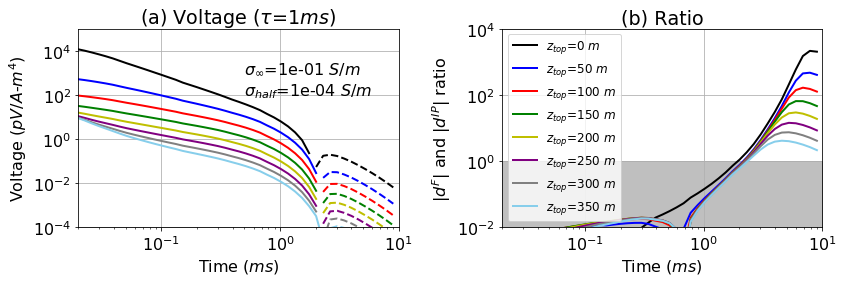

In [10]:
depths = abs(np.arange(9)*dz)
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$z_{top}$=%.0f $m$")%(depth) for depth in depths]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(8):
    data_p, data_n = get_dobs_pn(data_list_siginf_sig_1[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(8):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_siginf_sig_1[i].flatten()/data_em_list_siginf_sig_1[i].flatten()), linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=12)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time ($ms$)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')

ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-2, 1e4)
plt.tight_layout()    
ax.set_title("(a) Voltage ($\\tau$=1$ms$)")
ax1.set_title("(b) Ratio")
ax.text(0.5, 1e3, ("$\sigma_{\infty}$=%.0e $S/m$")%(1e-1))
ax.text(0.5, 1e2, ("$\sigma_{half}$=%.0e $S/m$")%(1e-4))
tmin, tmax = 2e-5*ms, 0.01*ms
ax.fill_between([tmin, tmax], np.r_[noise_floor, noise_floor], y2=np.r_[1e-8, 1e-8], color='grey', alpha=0.5)
ax1.fill_between([tmin, tmax], np.r_[1e0, 1e0], y2=np.r_[1e-2, 1e-2], color='grey', alpha=0.5)

fig.savefig(figdir+"data_depth_2", dpi=300)

# Variable $\tau$

In [11]:
dz = 50.
sig_1 = 0.0001
data_list_tau = []
data_em_list_tau = []
data_ip_list_tau = []
taus = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1., 3., 10.]
for tau_temp in taus:
    for i in range(8):
        sig_2 = sig_1*1000.
        sigmaInf = np.ones(mesh.nC) * sig_1
        airind = mesh.gridCC[:,2]>0.
        blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz*i)&(mesh.gridCC[:,2]<-dz*i))
        sigmaInf[airind] = 1e-8
        sigmaInf[blkind] = sig_2
        eta_CC, tau_CC, c_CC = 0.1, tau_temp, 0.7
        print (eta_CC, tau_CC, c_CC)
        eta = np.zeros(mesh.nC)
        eta[blkind] = eta_CC
        tau = np.ones(mesh.nC) * tau_CC
        c = np.ones(mesh.nC) * c_CC 

        rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
        src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
        survey_emip = Survey([src_emip])
        prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
        prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_emip.Solver = PardisoSolver
        prb_emip.pair(survey_emip)
        m = np.r_[sigmaInf, eta, tau, c]
        data = survey_emip.dpred(m)
        data_list_tau.append(data) 

        rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
        src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
        survey_em = Survey([src_em])
        prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
        prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_em.Solver = PardisoSolver
        prb_em.pair(survey_em)
        m = np.r_[sigmaInf, eta, tau, c]
        data_em = survey_em.dpred(m)
        data_em_list_tau.append(data_em) 
        data_ip_list_tau.append(data - data_em)

0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 3.0 0.7
0.1 3.0 0.7
0.1 3.0 0.7
0.1 

0.01


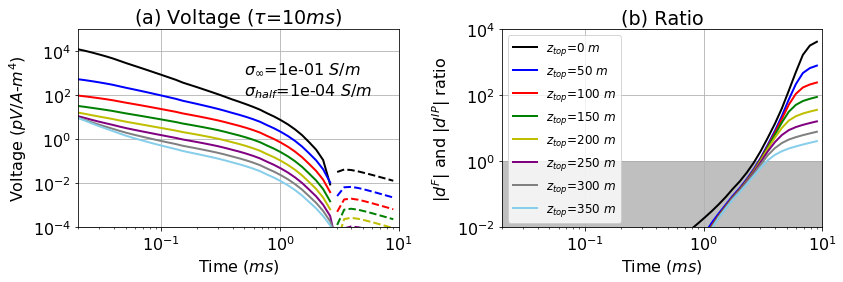

In [12]:
ii = 4
i_start = 8*ii
print (taus[ii])
depths = abs(np.arange(8)*dz)
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$z_{top}$=%.0f $m$")%(depth) for depth in depths]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
iteration = np.arange(8)+i_start
for jj, i in enumerate(iteration):
    data_p, data_n = get_dobs_pn(data_list_tau[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[jj], lw=2)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[jj], lw=2)
for jj, i in enumerate(iteration):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_tau[i].flatten()/data_em_list_tau[i].flatten()), linestyle='-', color=colors[jj], lw=2)
ax1.legend(legends, fontsize=12)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time ($ms$)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')

ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-2, 1e4)
plt.tight_layout()    
ax.set_title("(a) Voltage ($\\tau$=10$ms$)")
ax1.set_title("(b) Ratio")
ax.text(0.5, 1e3, ("$\sigma_{\infty}$=%.0e $S/m$")%(1e-1))
ax.text(0.5, 1e2, ("$\sigma_{half}$=%.0e $S/m$")%(1e-4))
tmin, tmax = 2e-5*ms, 0.01*ms
ax.fill_between([tmin, tmax], np.r_[noise_floor, noise_floor], y2=np.r_[1e-8, 1e-8], color='grey', alpha=0.5)
ax1.fill_between([tmin, tmax], np.r_[1e0, 1e0], y2=np.r_[1e-2, 1e-2], color='grey', alpha=0.5)

fig.savefig(figdir+"data_depth_tau", dpi=300)


In [13]:
icount=0
max_depth = []
for ii, tau_temp in enumerate(taus):
    max_depth_temp = np.zeros(len(depths))
    for jj, depth in enumerate(depths):
        data = -data_list_tau[icount]
        inds_n = data<0.
        if inds_n.sum() == 0:
            pass
        elif (-data[inds_n]/moment).max() > noise_floor:
            max_depth_temp[jj] = depth
        icount += 1
    max_depth.append(max_depth_temp.max())        

In [14]:
dz = 50.
sig_1 = 0.001
data_list_tau_1 = []
data_em_list_tau_1 = []
data_ip_list_tau_1 = []
taus = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1., 3., 10.]
for tau_temp in taus:
    for i in range(8):
        sig_2 = sig_1*100.
        sigmaInf = np.ones(mesh.nC) * sig_1
        airind = mesh.gridCC[:,2]>0.
        blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz*i)&(mesh.gridCC[:,2]<-dz*i))
        sigmaInf[airind] = 1e-8
        sigmaInf[blkind] = sig_2
        eta_CC, tau_CC, c_CC = 0.1, tau_temp, 0.7
        print (eta_CC, tau_CC, c_CC)
        eta = np.zeros(mesh.nC)
        eta[blkind] = eta_CC
        tau = np.ones(mesh.nC) * tau_CC
        c = np.ones(mesh.nC) * c_CC 

        rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
        src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
        survey_emip = Survey([src_emip])
        prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
        prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_emip.Solver = PardisoSolver
        prb_emip.pair(survey_emip)
        m = np.r_[sigmaInf, eta, tau, c]
        data = survey_emip.dpred(m)
        data_list_tau_1.append(data) 

        rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
        src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
        survey_em = Survey([src_em])
        prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
        prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_em.Solver = PardisoSolver
        prb_em.pair(survey_em)
        m = np.r_[sigmaInf, eta, tau, c]
        data_em = survey_em.dpred(m)
        data_em_list_tau_1.append(data_em) 
        data_ip_list_tau_1.append(data - data_em)

0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0001 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.0003 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.003 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.01 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.03 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.1 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 0.3 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 1.0 0.7
0.1 3.0 0.7
0.1 3.0 0.7
0.1 3.0 0.7
0.1 

In [16]:
icount=0
max_depth_1 = []
for ii, tau_temp in enumerate(taus):
    max_depth_1_temp = np.zeros(len(depths))
    for jj, depth in enumerate(depths):
        data = -data_list_tau_1[icount]
        inds_n = data<0.
        if inds_n.sum() == 0:
            pass
        elif (-data[inds_n]/moment).max() > noise_floor:
            max_depth_1_temp[jj] = depth
        icount += 1
    max_depth_1.append(max_depth_1_temp.max())        

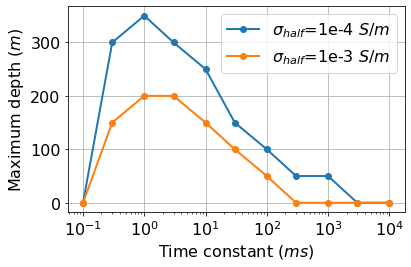

In [17]:
fig = plt.figure()
plt.semilogx(np.array(taus)*1e3, max_depth, 'o-', lw=2)
plt.semilogx(np.array(taus)*1e3, max_depth_1, 'o-', lw=2)
plt.xlabel("Time constant ($ms$)")
plt.ylabel("Maximum depth ($m$)")
plt.grid(True)
plt.tight_layout()
plt.legend(("$\sigma_{half}$=1e-4 $S/m$", "$\sigma_{half}$=1e-3 $S/m$"))
fig.savefig(figdir+"tau-vs-depth", dpi=200)